In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.callback.fp16 import *
import torchvision.models as models

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_path = 'C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/'

In [2]:
path_imgs = Path('Breast Cancer Data')

In [3]:
def get_dls():
    img_block = DataBlock(
        blocks=(ImageBlock, CategoryBlock) 
        ,get_items=get_image_files 
        ,splitter=RandomSplitter(valid_pct=0.25, seed=123)
        ,get_y=parent_label
        ,item_tfms=Resize(50)
    )
    return img_block.dataloaders(path_imgs, num_workers=0, bs=256)

In [4]:
dls = get_dls()

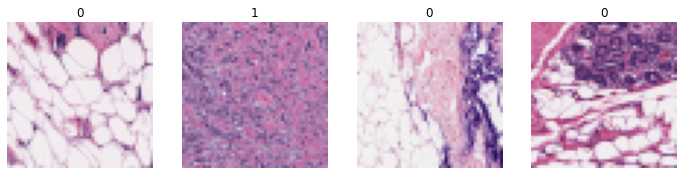

In [5]:
dls.valid.show_batch(max_n=4, nrows=1)

In [6]:
learn = cnn_learner(dls, models.mobilenet_v2, cut=-1, metrics=[accuracy, error_rate])

In [7]:
learn.unfreeze()

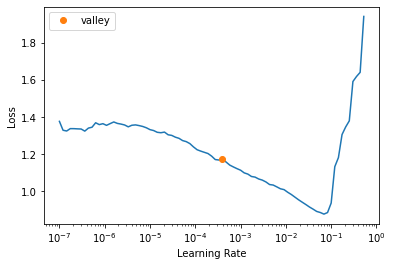

In [8]:
lr_valley = learn.lr_find(suggest_funcs=(valley))

In [9]:
learn.fit_one_cycle(4, lr_valley)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.310360,0.319143,0.871851,0.128149,08:19
1,0.289489,0.273081,0.889796,0.110204,08:30
2,0.245803,0.242276,0.898957,0.101043,09:09
3,0.220821,0.236352,0.902734,0.097266,10:38


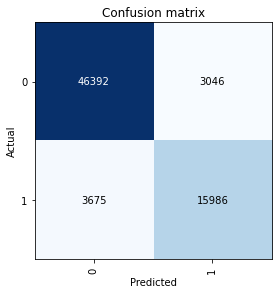

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

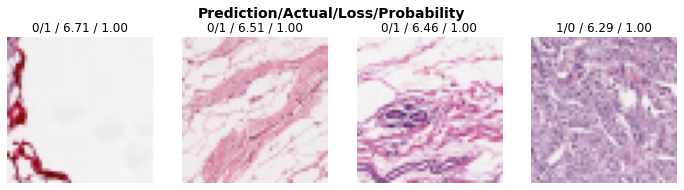

In [11]:
interp.plot_top_losses(4, nrows=1)

In [12]:
learn.export(fname='breast_cancer_fastai_mobilenet_v2.pkl')

### Inference

In [9]:
learn_inf = load_learner('breast_cancer_fastai_mobilenet_v2.pkl')

In [10]:
# fns = get_image_files('C:/Users/light/Documents/16896')
# fns

In [11]:
# for fn in fns:
#     img_upload = SimpleNamespace(data = [fn])
#     img = PILImage.create(img_upload.data[-1])
#     pred,pred_idx,probs = learn_inf.predict(img)
#     print(fn.name, pred, pred_idx, probs)

In [12]:
learn_inf.dls.transform

(#2) [[noop:
encodes: (object,object) -> noopdecodes: , PILBase.create:
encodes: (Path,object) -> create
(str,object) -> create
(Tensor,object) -> create
(ndarray,object) -> create
(bytes,object) -> createdecodes: ],parent_label:
encodes: (object,object) -> parent_labeldecodes: ]

In [13]:
labels = learn_inf.dls.vocab
labels

['0', '1']

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms

pytorch_model = learn_inf.model.eval()
softmax_layer = torch.nn.Softmax(dim=1)

final_model = nn.Sequential(
    pytorch_model,
    softmax_layer
)

In [15]:
torch.onnx.export(
    final_model, 
    torch.randn(1, 3, 50, 50, requires_grad=False),
    "breast_cancer_fastai_mobilenet_v2.onnx",
    export_params=True,
    input_names=["input"],
    output_names=["output"]
)

In [16]:
import onnx

# Load the ONNX model
model = onnx.load('breast_cancer_fastai_mobilenet_v2.onnx')

# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
#onnx.helper.printable_graph(model.graph)

In [17]:
import numpy as np
import onnxruntime as rt

np.set_printoptions(suppress=True)

In [18]:
from PIL import Image

def image_transform_onnx(path: str, size: int) -> np.ndarray:
    '''Image transform helper for onnx runtime inference.'''

    image = Image.open(path)
    image = image.resize((size,size))
    print(image.shape, image.mode)


    # now our image is represented by 3 layers - Red, Green, Blue
    # each layer has a 224 x 224 values representing
    image = np.array(image)
    print('Conversion to tensor: ',image.shape)

    # dummy input for the model at export - torch.randn(1, 3, 224, 224)
    image = image.transpose(2,0,1).astype(np.float32)
    print('Transposing the tensor: ',image.shape)

    # our image is currently represented by values ranging between 0-255
    # we need to convert these values to 0.0-1.0 - those are the values that are expected by our model

    print('Integer value: ', image[0][0][40])
    image /= 255
    print('Float value: ', image[0][0][40])

    # expanding the alread existing tensor with the final dimension (similar to unsqueeze(0))
    # currently our tensor only has rank of 3 which needs to be expanded to 4 - torch.randn(1, 3, 224, 224)
    # 1 can be considered the batch size

    image = image[None, ...]
    print('Final shape of our tensor', image.shape, '\n')
    return image

In [19]:
img_tensor_onnx = image_transform_onnx('16896/1/16896_idx5_x151_y801_class1.png', 50)

(50, 50) RGB
Conversion to tensor:  (50, 50, 3)
Transposing the tensor:  (3, 50, 50)
Integer value:  200.0
Float value:  0.78431374
Final shape of our tensor (1, 3, 50, 50) 



In [20]:
# initialize onnx runtime inference session
sess = rt.InferenceSession('breast_cancer_fastai_mobilenet_v2.onnx')

# input & output names
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

# input dimensions
input_dims = sess.get_inputs()[0].shape

input_name, output_name, input_dims

('input', 'output', [1, 3, 50, 50])

In [21]:
results = sess.run([output_name], {input_name: img_tensor_onnx})[0]
labels[np.argmax(results)], results, labels

('0', array([[0.839252  , 0.16074799]], dtype=float32), ['0', '1'])